Bayesian System Identification of a Harmonic Oscillator using Probabilistic Programming
===========================

In this problem you will use probabilistic programming to infer the mass, spring constant, damping, and initial velocity of a Mass-Spring-Damper system, given only noisy measurements of that system.

For this, you can use any probabilistic programming library that you like (e.g., PyMC3, Tensorflow Probability, Pyro, Edward, Turing, etc.). If you want to leverage some of the examples from class then we happened to use PyMC3, however this problem is still solvable using any other library.

In [1]:
# If using PyMC3 you may want to make sure PyMC3 and arviz is installed
# Uncomment below, if so, otherwise 
#!pip install arviz
# or, if you need pymc3 as well:
#!pip install pymc3[plots]
# Alternatively, you can run this in a colab instance, like shown in class
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

     |████████████████████████████████| 1.4MB 6.2MB/s 
     |████████████████████████████████| 4.3MB 16.7MB/s 
     |████████████████████████████████| 296kB 40.7MB/s 
     |████████████████████████████████| 911kB 6.7MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7
     |████████████████████████████████| 2.8MB 5.3MB/s 
  Created wheel for Theano: filename=Theano-1.0.4-cp36-none-any.whl size=2667178 sha256=be119499d583c0c564aa4e4973db1cb208b106e553a6d272ca614fb8e15d4f7f
  Stored in directory: /root/.cache/pip/wheels/88/fb/be/483910ff7e9f703f30a10605ad7605f3316493875c86637014
Successfully built Theano
  Found existing installation: Theano 1.0.5
    Uninstalling Theano-1.0.5:
      Successfully uninstalled Theano-1.0.5


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Model Definition: Damped Harmonic Oscillator
From Dynamics class, we can recall that the solution to an unforced damped harmonic oscillator (like a Mass-Spring-Damper System with no external forces on it) is:
$$
\hat{y}(t) = A\exp(\frac{-c t}{2m})\sin(\omega t+\phi)
$$
where
$$
\begin{eqnarray}
  \omega &=& \frac{\sqrt{4mk-c^2}}{2m}\\
  B &=& \frac{v_0+y_0 \cdot \frac{c}{2m}}{\omega} \\
  \phi &=& \tan^{-1}\left(\frac{y_0}{B}\right)\\
  A &=& \sqrt{y_0^2 +  B^2}
\end{eqnarray}
$$
and $m$, $c$, $k$, $y_0$, and $v_0$ are the mass, damping coefficient, spring constant, initial position, and initial velocity, respectively.

However, in this problem we will assume that we are only given position measurement data, which is slightly noisy, and that we want to infer (using probabilistic programming) the possible values for the mass, spring constant, damping coefficient, and initial velocity, given that we know the system started from $y_0=1$.

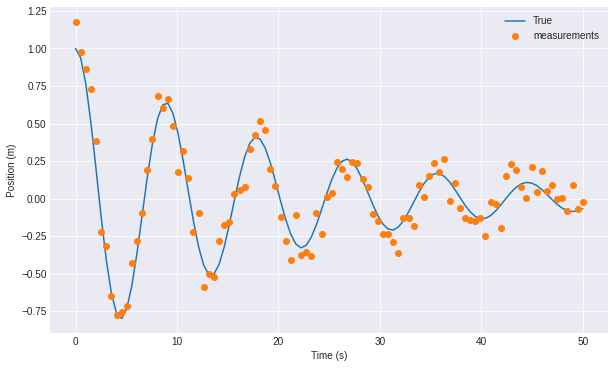

In [3]:
# Code to generate the noisy measurements
# Number of Timesteps
T = 100
np.random.seed(0)

# Textbook solution to Unforced Mass-Spring-Damper Harmonic Oscillator
def MSD(t,m,k,c,y0,v0):
  omega = np.sqrt(4*m*k-c**2)/(2*m)
  B = (v0+y0*c/(2*m))/omega 
  phi = np.arctan(y0/B)
  A = np.sqrt(y0**2 +  B**2)
  y = A*np.exp(-c*t/(2*m))*np.sin(omega*t+phi)
  return y

# Simulate the true system:
time_vec = np.linspace(0, 50, T)
ytrue = MSD(time_vec, 
            m=10, 
            k=5,
            c=1,
            y0=1,
            v0=0)

# Add Measurement Noise
measurements = ytrue + 0.1*np.random.randn(T)

plt.figure(figsize=(10, 6))
plt.plot(time_vec, ytrue, label='True')
plt.plot(time_vec, measurements,'o', label='measurements')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.show()


# Task1: Build the Probabilistic Model

Using the probabilistic programming language of your choice, build a probabilistic model of the position as a function of time, with the following prior beliefs about the other system parameters:
$$
P(\mathbf{y},m,k,c,v_0|T) = \sum_{t \in T} {\cal N}(y_t | \hat{y}(t,m,k,c,v_0),\sigma^2)P(m)P(c)P(k)P(v_0)P(sigma)
$$
where
$$
\begin{eqnarray}
  P(m)&\sim & {\cal N}(\mu_m=10, \sigma_m = 0.01) \\
  P(k)&\sim & {\cal N}(\mu_k=10, \sigma_k = 5)  \\
  P(c)&\sim & {\cal N}(\mu_c=5, \sigma_c = 2)  \\
  P(v_0)&\sim & {\cal N}(\mu_{v_0}=0, \sigma_{v_0} = 5)  \\
  P(sigma )&\sim & \mathrm{Gamma}(\alpha = 0.2, \beta = 1) \\
\end{eqnarray}
$$

While this seems like perhaps a complicated model, using probabilistic programming this basically means:

1. Instantiate probabilistic variables `m`,`c`,`k`, `v0` and `sigma` with the appropriate Normal and Gamma prior distributions.
2. Use them when computing the dynamics solution above.
3. Set the output variable `y` to be the observed variable using `measurements` as the observations.
4. Sample the model with N=15K samples. (e.g., I would suggest the NUTS sampler with 15K samples and using around 2000 tuning samples). Use at least two chains for comparison sake later.

Hint: If you have issues getting your sampling chains to converge, you can try: (1) increasing the number of samples, (2) increasing the number of tuning samples you allow `tuning = ####`, or (3) increasing the target acceptance rate for the MCMC samples (`target_accept=0.95` or `.99`, etc.). You can also increase the number of independent chains via `chains=3` or `4` or other numbers, though I would try increasing the number of samples first.

Hint 2: You will notice that our prior belief about the mass is really tight ($\sigma_m=0.01$). This is on purpose and not a typo. Task 3 will explore what happens if this is not the case. In more realistic problems, we may not know the mass with such accuracy, though for this task we will assume that we do.

Hint 3: Particularly eagle-eyed students may question the use of, e.g., the Normal distribution on parameters like Mass or damping coefficient, etc., since, technically, that could mean there is a probability of getting a negative mass or stiffness or damping etc. which is not physically sound and so forth. This is true, and it would be in fact far more reasonable to pick a distribution on the positive reals, such as the Log-Normal, Half-Cauchy, Truncated Normal, Exponential, or others. Feel free to do so if you like, but for simplicity sake I am asking everyone to do Normals for now.


In [4]:
# Your Model Code Here
import pymc3 as pm

In [5]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    m = pm.Normal('m', mu = 10, sd = 0.01)
    k = pm.Normal('k', mu = 10, sd = 5)
    c = pm.Normal('c', mu = 5, sd = 2)
    v0 = pm.Normal('v0', mu =0, sd=5)
    sigma = pm.Gamma('sigma', alpha = 0.2, beta = 1)
    
    # Expected value of outcome
    muy = MSD(time_vec, 
            m=m, 
            k=k,
            c=c,
            y0=1,
            v0=v0)
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=muy, sd=sigma, observed=measurements)

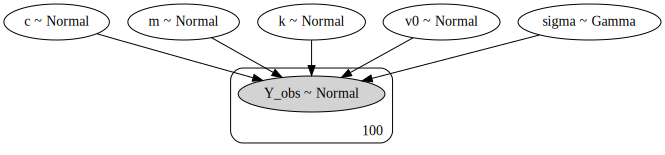

In [6]:
pm.model_to_graphviz(basic_model)

In [7]:
# Your Sampling Code Here
pm.sample?

In [14]:
%%time
# Sampling
with basic_model:
    # draw posterior samples
    mc_trace = pm.sample(15000, tune=2000,target_accept=0.99,cores=30,chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 30 jobs)
NUTS: [sigma, v0, c, k, m]
Sampling 2 chains, 1,572 divergences: 100%|██████████| 34000/34000 [04:05<00:00, 138.32draws/s]
There were 753 divergences after tuning. Increase `target_accept` or reparameterize.
There were 819 divergences after tuning. Increase `target_accept` or reparameterize.


CPU times: user 31.5 s, sys: 2.03 s, total: 33.5 s
Wall time: 4min 13s


# Task 2: Inspect the model

Now that you have your samples, go ahead and inspect the output of the probabilistic program. Specifically:

## Plot the trace plots of the uncertain parameters.




/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a6c0526a0>,
      dtype=object)

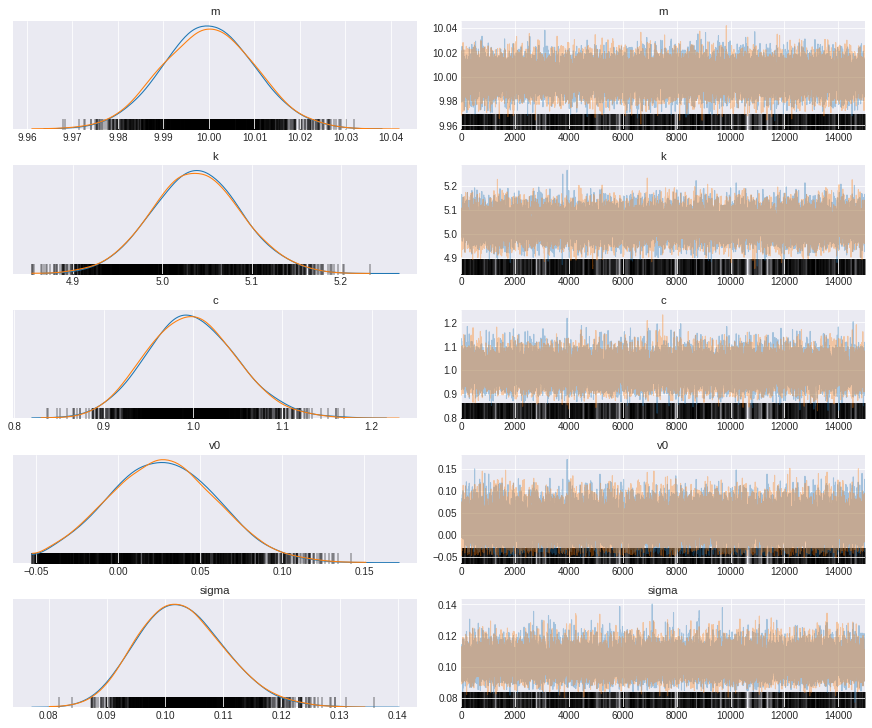

In [15]:
# Your Code here
pm.traceplot(mc_trace)

Q: Do the different chains produce similar estimates of the parameters? Has the model seemed to converge? What evidence are you using to assess either answer?

A: Yes. The two chains produced almost similar estimates of the parameters. Although the divergence in the description of results of the model is not zero, we can see that the true means of the parameters lie within the distributions. The number of divergence for both traces is about 800 which is significantly less than the total number of samples. In one run, I got zero divergence (with #sampels=30000 and tune=3000) but the true values were not even within the distributions.
The above graph helps us to asses the convergence. We can see the plots on the right side of the above figure is noisy and that's what we want for reliable answers. Chances are increasing the number of samples help with decreasing the divergence. Since, theoretically, if number of samples in MCMC increases to infinity, the estimated values should converge to the true values. In here, only the estimated m is similar to the true mean and that's because the distribution that we used for m has similar mean to the true mean and also the standard deviation of it was very tight. But the other parameters started off with a value further from the true mean with larger variability.



## Provide the Summary statistics of the uncertain parameters
That is, compute the mean, and 95% posterior interval for the main system parameters (mass, spring constant, damping).

In [10]:
# Your code here
pm.summary(mc_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m,9.999,0.010,9.981,10.018,0.000,0.000,711.0,709.0,753.0,20531.0,1.01
k,15.373,3.715,5.025,20.205,1.077,0.781,12.0,12.0,25.0,9.0,1.05
c,7.148,2.091,1.440,10.168,0.591,0.428,13.0,13.0,27.0,9.0,1.05
v0,-2.387,0.899,-3.477,0.260,0.272,0.198,11.0,11.0,26.0,13.0,1.05
sigma,0.362,0.040,0.262,0.422,0.011,0.008,13.0,13.0,26.0,8.0,1.05


Q: Given that you know the true system parameters that generate the data (seen in the code at the top that generated the measurements), do these estimates seem reasonable? Do their 95% credible intervals include the correct parameters? Are any unreasonable? Explain why.

A: The 95% CI include the true parameters in all the cases. The estimated mean for m is very close to the true mean for m with small standard error. However, the estimated mean for k and c become skewed to the higher bound of their distributions. The estimated mean for v0 is negative which is not reasonable, but that could be becauce of the high standard error that we considered in the first place. The 95% CI still includes the 0 but the true mean does not make sense. Overall, these sets of parameters although somewhat far from the true values could produce y values close to the measurements.

## Plot the 95% CI bound on the predicted true function
Using the samples you gathered while running your probabilistic program, produce a plot that compares (with time on the x-axis):

1. The provided measurements (`measurements`)
2. The true function (`ytrue`)
3. The mean predicted function (from your model)
4. The 95% CI upper bound on the function over time (from your model)
5. The 95% CI lower bound on the function over time (from your model).

Ideally, your 95% CI should contain the true function, if your probabilistic program is well-calibrated (i.e., has an appropriate measure of its own uncertainty).

In [ ]:
# Your Code Here

In [24]:
y_predicted_mean = MSD(time_vec, 
            m=mc_trace['m'][0], 
            k=mc_trace['k'][0],
            c=mc_trace['c'][0],
            y0=1,
            v0=mc_trace['v0'][0])
y_lb = MSD(time_vec, 
            m=mc_trace['m'][2], 
            k=mc_trace['k'][2],
            c=mc_trace['c'][2],
            y0=1,
            v0=mc_trace['v0'][2])
y_ub = MSD(time_vec, 
            m=mc_trace['m'][3], 
            k=mc_trace['k'][3],
            c=mc_trace['c'][3],
            y0=1,
            v0=mc_trace['v0'][3])

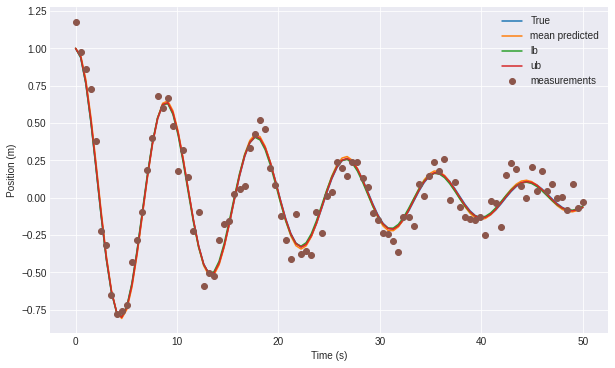

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(time_vec, ytrue, '-',label='True')
plt.plot(time_vec, y_predicted_mean, '-',label='mean predicted')
plt.fill_between(time_vec, y_lb, y_ub, alpha=0.3, color='tab:red')
plt.plot(time_vec, y_lb, '-',label='lb')
plt.plot(time_vec, y_ub, '-',label='ub')
plt.plot(time_vec, measurements, 'o', label='measurements', color='tab:brown')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.show()

The above graph shows that the 95% CI contains the true function. 

## Plot the posterior covariance between the system parameters

Specifically, plot the pairwise joint probability density between the posterior distributions of the variables for mass, spring constant, and damping. You can do this by plotting for each point on the trace, the pairwise relationship between m vs k, k vs c, and m vs c.

Hint: Using a function like pairplot will be useful here, since such functions draw joint probability points automatically.

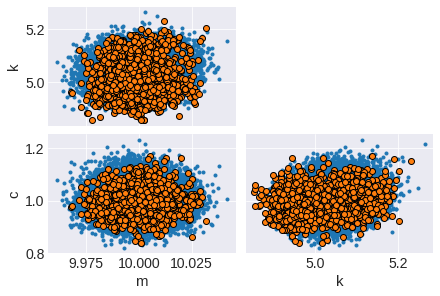

In [44]:
# Your Code Here
pm.pairplot(mc_trace, var_names=['m', 'k', 'c'], divergences=True);

Q: What do you notice, if anything about the covariance between m, c, and k?

A: We can see that k and m covary positively, the elipse for c and m is almost flat. Seems like the covariance between them is close to zero. Finally, c and k also seems covary positively for values higher than their true means. However, it is hard to see clear relationshio between variabbles. Specially there is very week relationship with m probably because of small standard deviation. 

# (743 Only) Task 3: Uncertain mass

Above, we assumed that we had a fairly good prior idea of the mass of the system. What if we were less sure and wanted to try to infer the mass as well?

To see how this would turn out, re-run your original model from above, except this time make the prior belief about the mass less certain -- perhaps you are not sure exactly how much the mass might weigh.... That is, instead of making your prior distribution on the mass $P(m) \sim  {\cal N}(\mu_m=10, \sigma_m = 0.01)$, *instead* increase the standard deviation to $\sigma_m = 3$ -- a significant increase in prior uncertainty (e.g., the mass could now range anywhere from around 1-ish to 20-ish.

Re-Run your probabilistic program from above, and include some of the same outputs such as (1) the trace plot, (2) the summary statistics of the parameters, and (3) the posterior covariance between m, c, and k. Note any changes. Likewise, re-plot the predicted displacement vs t as you did above (including the upper and lower bounds). Note any changes.

Warning: Convergence on these sampling steps may be signficantly slower than what you saw for Task 2, so budget waiting time accordingly.


In [37]:
# Your Model code here
basic_model2 = pm.Model()

with basic_model2:
    # Priors for unknown model parameters
    m = pm.Normal('m', mu = 10, sd = 3)
    k = pm.Normal('k', mu = 10, sd = 5)
    c = pm.Normal('c', mu = 5, sd = 2)
    v0 = pm.Normal('v0', mu =0, sd=5)
    sigma = pm.Gamma('sigma', alpha = 0.2, beta = 1)
    
    # Expected value of outcome
    muy = MSD(time_vec, 
            m=m, 
            k=k,
            c=c,
            y0=1,
            v0=v0)
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=muy, sd=sigma, observed=measurements)

INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


In [15]:
# Your Sampling Code here

In [38]:
%%time
# Sampling
with basic_model2:
    # draw posterior samples
    mc_trace2 = pm.sample(15000, tune=2000,target_accept=0.99,cores=60,chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 60 jobs)
NUTS: [sigma, v0, c, k, m]
Sampling 2 chains, 9,366 divergences: 100%|██████████| 34000/34000 [02:32<00:00, 222.71draws/s]
There were 8911 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.09261585848792528, but should be close to 0.99. Try to increase the number of tuning steps.
There were 455 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9102616830397698, but should be close to 0.99. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 38.1 s, sys: 3.6 s, total: 41.7 s
Wall time: 2min 40s


/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a79ef42b0>,
      dtype=object)

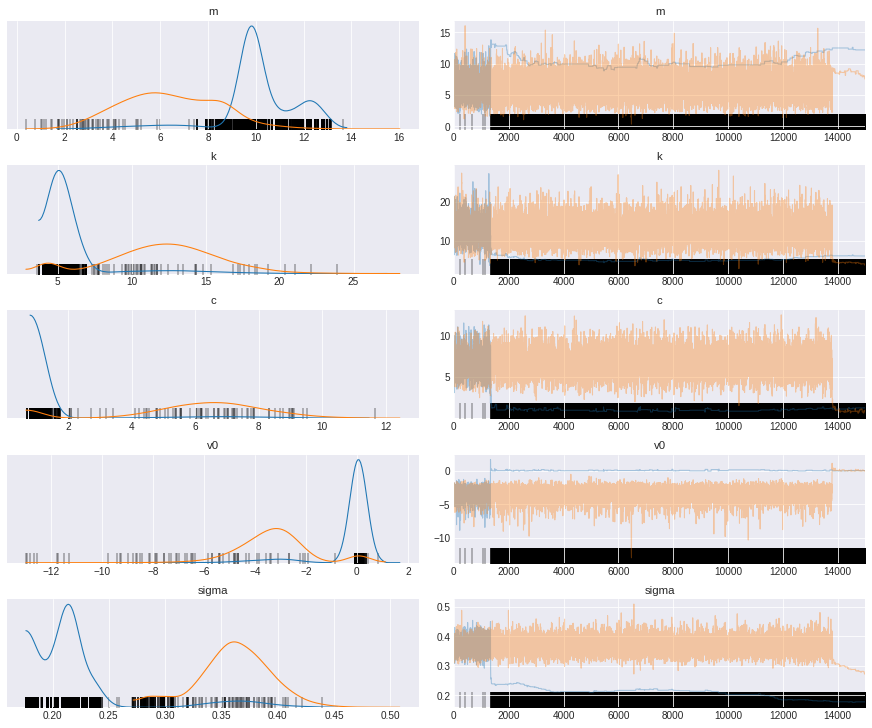

In [40]:
# Your Visualization/Inspect code here
pm.traceplot(mc_trace2)
# please see the results of visualization for the run provided in the last section. 

Q: Do you get the same results trace plot or summary statistics as before? If not, what has changed?

A: Running the sampling with the same sampling number and tune produced different results for the two traces, unlike the previous case. One trace (the blue graphs in above) produces more reasonable result and the true parameters of m, k, and v0 but not c lie inside the predicted distrbutions. But the autocorrelation graph after some number of samples become less noisy as compared to the orange trace. More noise in the right graph indicates more reliable responses. Also, we can see the number of divergences produced as result of pm.sample increased to 9,366 (8911 for one trace and 455 for the other), which further shows the results of one trace is better than the other.  These results were really bad. So, by increasing the tune, I attemped at producing better results. Below (after the hint), I included the results of one of my runs that produced better results in terms of convergence. In below, we can see that both traces produce similar results, and true values lies within the distributions.

Q: How did the posterior covariance between m, k, and c change? What do you think is causing this change and why would this cause possible problems for estimating the mass, spring constant, and damping? Please see the below graph that is included for covariance. We can see the posterior covariance between m,k, and c become significantly different form the above case. m and k, c and m, and c and k clearly covary with each other positively. The higher standard deviation for m let all the paramters to covary with each other positively and a clear change can be observed. 
What really happens is that, as far as the ratio between the parameters stay the same as shown in cases 1-3, y remains the same and this can be seen based on the formula above, for example c/m remains 10 in all cases and for 1-3 cases k/m = 2, and c/k=1/5. So, the sampling might find different values but the ratio between the parameters is important because those ratios characterize the shape of y. 

Hint: To help understand the above, see the below code where we plot the behavior of four different (deterministic) systems:

1. m = 10, k = 5, c = 1
2. m = 20, k = 10, c = 2
3. m = 30, k = 15, c = 3
4. m = 30, k = 20, c = 3

What is going on here? Look at the formulas above for $y$, $B$, and $\omega$. What happens when we change things in a fashion similar to cases 1-3? How might this affect the likelihood $P(\mathbf{y},m,k,c,v_0|T)$? What might this mean for our estimates of the uncertain parameters m, c, and k? This may help you think through your answer to the above question.


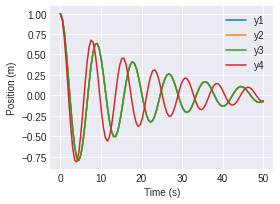

In [41]:

# Plot a few example systems with different masses, spring constants, and damping
y1 = MSD(time_vec, 
           m=10, k=5, c=1, y0=1, v0=0)
y2 = MSD(time_vec, 
           m=20, k=10, c=2, y0=1, v0=0)
y3 = MSD(time_vec, 
           m=30, k=15, c=3, y0=1, v0=0)

y4 = MSD(time_vec, 
           m=30, k=20, c=3, y0=1, v0=0)


plt.figure(figsize=(4, 3))
plt.plot(time_vec, y1, label='y1')
plt.plot(time_vec, y2, label='y2')
plt.plot(time_vec, y3, label='y3')
plt.plot(time_vec, y4, label='y4')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.show()

In [42]:
%%time
# Sampling to get better convergence
with basic_model2:
    # draw posterior samples
    mc_trace2 = pm.sample(15000, tune=10000,target_accept=0.99,cores=100,chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 100 jobs)
NUTS: [sigma, v0, c, k, m]
Sampling 2 chains, 1,358 divergences: 100%|██████████| 50000/50000 [44:01<00:00, 18.93draws/s]
There were 756 divergences after tuning. Increase `target_accept` or reparameterize.
There were 602 divergences after tuning. Increase `target_accept` or reparameterize.


CPU times: user 1min 3s, sys: 5.86 s, total: 1min 9s
Wall time: 44min 8s


/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a6cf9d4e0>,
      dtype=object)

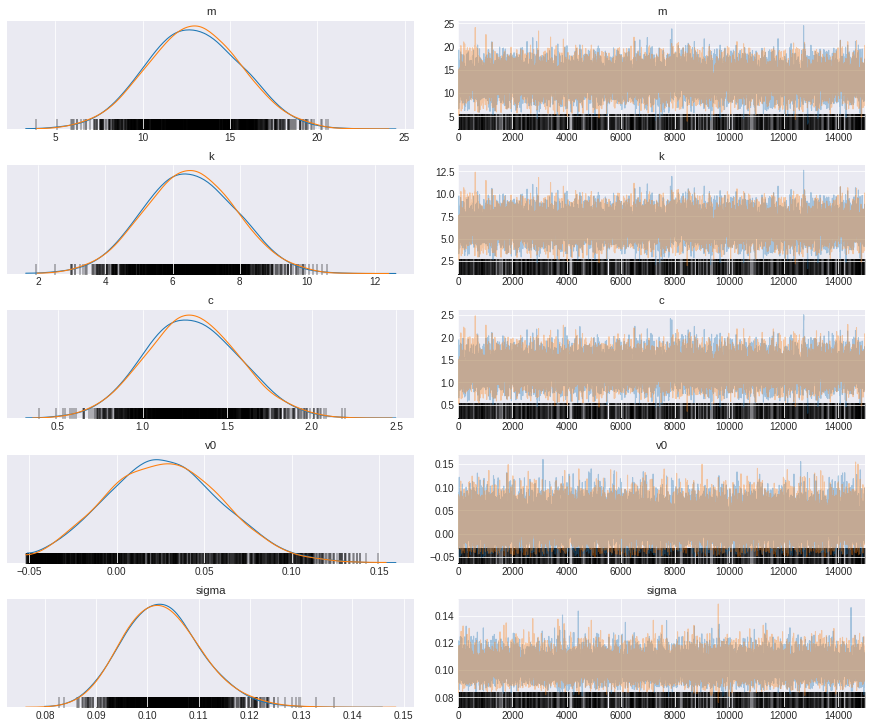

In [45]:
pm.traceplot(mc_trace2)


We can see the traces are more similar as compared to the previous run provided in the above. Both traces contain the true values for all the parameters and divergence become decreased significantly.



In [48]:
pm.summary(mc_trace2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m,12.951,2.679,7.938,17.932,0.029,0.020,8650.0,8650.0,8638.0,10502.0,1.0
k,6.525,1.351,3.972,9.018,0.015,0.010,8615.0,8615.0,8605.0,10433.0,1.0
c,1.296,0.276,0.793,1.833,0.003,0.002,8492.0,8492.0,8480.0,11061.0,1.0
v0,0.027,0.033,-0.034,0.087,0.000,0.000,11889.0,10634.0,11653.0,12080.0,1.0
sigma,0.103,0.008,0.089,0.117,0.000,0.000,14731.0,14518.0,14985.0,13445.0,1.0


The largest standard deviation for m produced largest confidence bound for m. But all the parameters are within 95% CI.

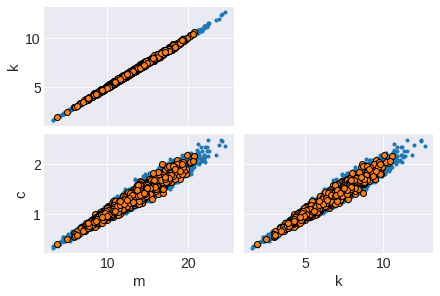

In [49]:
pm.pairplot(mc_trace2, var_names=['m', 'k', 'c'], divergences=True);

In [50]:
y_predicted_mean2 = MSD(time_vec, 
            m=mc_trace2['m'][0], 
            k=mc_trace2['k'][0],
            c=mc_trace2['c'][0],
            y0=1,
            v0=mc_trace2['v0'][0])
y_lb2 = MSD(time_vec, 
            m=mc_trace2['m'][2], 
            k=mc_trace2['k'][2],
            c=mc_trace2['c'][2],
            y0=1,
            v0=mc_trace2['v0'][2])
y_ub2 = MSD(time_vec, 
            m=mc_trace2['m'][3], 
            k=mc_trace2['k'][3],
            c=mc_trace2['c'][3],
            y0=1,
            v0=mc_trace2['v0'][3])

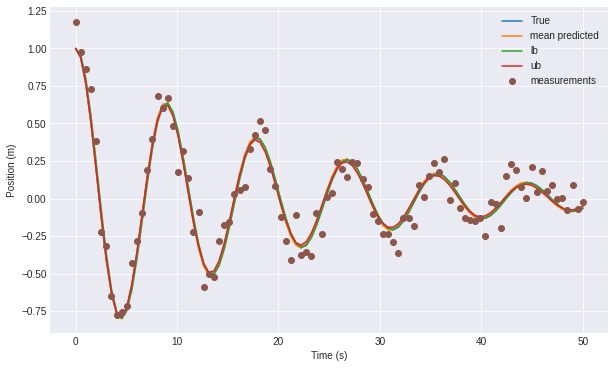

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(time_vec, ytrue, '-',label='True')
plt.plot(time_vec, y_predicted_mean2, '-',label='mean predicted')
plt.fill_between(time_vec, y_lb2, y_ub2, alpha=0.3, color='tab:red')
plt.plot(time_vec, y_lb2, '-',label='lb')
plt.plot(time_vec, y_ub2, '-',label='ub')
plt.plot(time_vec, measurements, 'o', label='measurements', color='tab:brown')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.show()